In [2]:
path_csv = "../../data/"
path_out = path_csv 
filename_test_csv = path_csv+"190_505_12-62_1678888371352.csv"
filename_test_json = "../../outcome/190_505_12-62_1678888371352.json"

In [3]:
import json 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

In [4]:
class Leek:
    path_data = "..\..\..\leek-wars-generator-Lks-v3\data"
    def __init__(self,dataOutcomeLeek):
        self.stats = dict()
        outcomeKeys = list(dataOutcomeLeek.keys())
        for enumFile in [enumFile for enumFile in os.listdir(Leek.path_data) if enumFile.startswith('enum')]:
            content = os.path.join(Leek.path_data,enumFile)
            f = open(content, "r")
            data=json.loads(f.read())
            filename = os.path.splitext(enumFile[len('enum'):])[0]
            self.stats.update({filename:[dict() for x in range(max(data["enumIndex"]))]})
            for i in range (len(data["enumIndex"])):
                enumName=data["enumName"][i].lower()
                if(enumName in outcomeKeys):
                    self.stats[filename][data["enumIndex"][i]].update({enumName:dataOutcomeLeek[enumName]})
                

def getLeekStats(filename_outcome_fight):          
    f = open(filename_outcome_fight)
    dataOutcome = json.load(f)
    dataOutcome=json.loads(dataOutcome)["leeks"]
    leeks = []
    for idx_leek in range(len(dataOutcome)):
        leek_file = Leek(dataOutcome[idx_leek])
        leeks.append(leek_file)
    return leeks

    

In [5]:

#convertie un df string en dictionnaire dont la clef est titre de la colonne str_col_id et la valeur la serie de valeur de la colonne
def toSeries(df,lst_dct, str_col_id,filter_val="[0]"):
    grp = df[[str_col_id, "ID_ENTITY","ID_TURN"]].query(str_col_id+"!="+filter_val).groupby("ID_ENTITY")[str_col_id,"ID_TURN"]
    
    for key, values in grp:
        tmp_grp = grp.get_group(key)
        lst_tmp = [0 for i in range(tmp_grp[tmp_grp.columns[0]].size)]
        for id_row , val_row in  tmp_grp.iterrows() :
            lst_tmp[val_row["ID_TURN"]]=ast.literal_eval(val_row[str_col_id])
        if (not key in lst_dct):
            lst_dct.update({key:dict()})

        lst_dct[key].update({str_col_id:lst_tmp})
        
    return lst_dct



                


In [6]:
#
def getEvolutionStats(df , lst_statNegStat =[["1700","LIFE","" ,"LOST_LIFE"]]):

    lst_evolutionStat = []
    #liste de dictionnaire ayant pour clef les titres dans lst_statNegStat 
    dct=dict()
    for lst in lst_statNegStat:
        for str_col_id in lst[1:]:
            if( bool(str_col_id)):
                dct=toSeries(df,dct,str_col_id)
        lst_evolutionStat.append(dct)

    lst_life = dict()
    #pour tous les dictionnaires de lst_evolutionStat calcule la somme des valeurs associé à chaque colonne 
    for dct in lst_evolutionStat:
        for k in dct.keys(): 
            lst_life.update({k:{}})
            for z in range(len(lst_statNegStat)) :
                lst = lst_statNegStat[z]
                lst_life[k].update({lst[1]:[int(lst[0])]})
                lst=lst[1:]
                sum_lst = lst_life[k][lst[0]]
                for i in range(1,len(dct[k][lst[0]])+1):
                    sum_lst.append(sum_lst[i-1])
                    neg=1
                    for str_col_id in lst:
                            if( not(bool(str_col_id))):
                                neg= -1
                                continue
                            dct_val = dct[k][str_col_id]
                            sum_lst[i] += neg*sum(dct_val[i-1])
    return lst_life




In [7]:
#df.drop(columns=["Unnamed: 0"],inplace=True)

def recap_fight(df ,  filter_lst_val = ["MOVE_TO"] , id_startWith ='ID' , seq_endWith='s' ,  n_key = ["fight_gen_idLeek","dimension", "seq_lens","mean","std","min","max"]):


    id_cols = [col for col in df.columns if col.startswith(id_startWith)]
    feat_cols = [col for col in df.columns if not(col in filter_lst_val  ) and not(id_startWith in col)  and not col.lower().endswith(seq_endWith) ] 

    #print(feat_cols)
    df2 = df.copy()[id_cols+feat_cols]


    for i in range(len(df2[feat_cols[0]])):
        for c in feat_cols :
            df2[c][i] = pd.to_numeric(ast.literal_eval(df2[c][i]))



    to_column_map = df2.set_index(id_cols)

    grouped = df2.groupby(id_cols[:-1])

    dict_gen = dict()

    obj_json_stats = dict. fromkeys(n_key)

    #.append(dictionary, ignore_index=True)
    n_df = pd.DataFrame(columns=n_key)
    for name, group in grouped:


        dict_val = dict()
        for f in feat_cols :
            dict_val.update({f:group[f].apply(pd.Series).stack().values})

        treshold = 0
        stats = dict()

        for f in dict_val.keys() :
            tmp_obj = obj_json_stats.copy()
            seq_lens = [0]
            for e in dict_val[f]:
                if(e > treshold):
                    seq_lens[-1]+=(1/len(dict_val[f]))
                elif(seq_lens[-1]>0):
                    seq_lens.append(0)

            tmp_obj["seq_lens"] = sum(seq_lens)/len(seq_lens)
            tmp_obj["mean"] = df2[f].mean()[0]
            tmp_obj["std"] = df2[f].std()
            tmp_obj["min"] = df2[f].min()[0]
            tmp_obj["max"] = df2[f].max()[0]
            
            tmp_obj["dimension"]=f

            tmp_obj["fight_gen_idLeek"]=name
            n_df = n_df.append(tmp_obj, ignore_index=True)

    return n_df 


In [8]:

def m_flatten(l):
    return [item for sublist in l for item in sublist]


def getlst_statNegStat( leek,str_lst = ["LIFE"]):
    lst_statNegStat =[]
    for str_col_id in str_lst:
        kl = leek.stats 
        t_l = str_col_id.lower()
        for k, e in kl.items():
            dct= e[0]
            if(t_l in  dct):
                    t_l2=t_l.upper()
                    lst_statNegStat.append([str(dct[t_l]),t_l2,"","LOST_"+t_l2])
                    break
    return lst_statNegStat


def getlstValAndLstIdx( filename_test_json ):
    leeks=getLeekStats( filename_test_json )
    lst_statNegStat = getlst_statNegStat( leeks[0])  
    lst_life = getEvolutionStats(df,lst_statNegStat)
    return lst_life , lst_statNegStat



def mergeNegStat (lst_life ,cols ,id_="ID_LEEK") :

    df2  = pd.DataFrame(columns=[id_]+cols  )

    for k in lst_life.keys():
        tmp_obj=dict({id_:k})
        tmp_obj.update(lst_life[k])
        df2=pd.concat([df2,pd.DataFrame([tmp_obj])], ignore_index=True)

    df3= pd.DataFrame(columns=[id_]+cols  )
    for col in cols : 
        t= df2.set_index([id_])[col].apply(pd.Series).stack()
        df4=t.to_frame()
        df4.rename(columns={0:col},inplace=True)
        if(col == cols[0]):
            df3=df4
        else:
            df3=df3.join(df4)
        
    return df3

def getColsFromLstStatNegStat(lst_statNegStat):
    return m_flatten([ list(filter(lambda x: x , e[1:2] )) for e in lst_statNegStat ])


def printAxis(df5,_id="ID_LEEK"):
    key_leek = list(set([e[0] for e in df5.index.values]))
    for i,k in enumerate(key_leek):
        df_o = df5.iloc[df5.index.get_level_values(_id) == k].reset_index(drop=True)
        if(i==0):
            ax = df_o.plot()
        else:
            df_o.plot(ax=ax)
        ax.legend(key_leek)


In [9]:

def getCumulStat(filename_test_json):
    lst_life , lst_statNegStat  = getlstValAndLstIdx(  filename_test_json )
    cols = getColsFromLstStatNegStat(lst_statNegStat)
    df5  = mergeNegStat (lst_life ,cols )
    return df5


In [10]:
def convert_XY_toCoord(XY):
    coef_x = XY//18
    coord_x = XY%18
    sign_x =  0 if coord_x < coef_x else -18
    coef_y = XY//17
    coord_y= XY%17
    sign_y = 0 if coord_y < coef_y  else -18
    
    tmp_x = None
    return (coord_y+sign_y,-(coord_x+sign_x))
     

In [11]:
def getCoords(df):
    dtr = dict()
    dtr = toSeries(df,dtr, "MAPS")
    coords = dict()
    for k in dtr.keys() :
        dtr_map = dtr[k]["MAPS"]
        coords.update({k:dict()})
        for i in range(len(dtr[k]["MAPS"])):
                if( len(dtr_map[i]) > 1 ):
                    coords[k].update({i:[convert_XY_toCoord(t_coord) for t_coord in dtr_map[i]]})
    return coords

In [12]:


def getMapPlot(df,coords):
    dict_tuple = dict()

    for k1 in coords.keys(): #pour chaque leek 
        dict_tuple.update({k1:[[],[]]})
        coords_1 = coords[k1]
        for k2 in coords_1.keys():#pour chaque tour 
            for coord in coords_1[k2]: # pour chaque position 
                for i , e in enumerate(coord): #pour chaque dimension de la position 
                    dict_tuple[k1][i].append(e)
    return dict_tuple

In [13]:
def dfFromCoordDict(dct, str_coord=["x","y"]):
    df_final = pd.DataFrame()
    print(dct)
    for k,v in dct.items():
        df = pd.DataFrame(columns=["ID_LEEK"]+str_coord)
        for i , l in enumerate(v) : 
            df[str_coord[i]] = l
        df["ID_LEEK"] = k
        df_final = pd.concat([df_final,df])
    return df_final.reset_index()



In [14]:

'''
def plotMap(dict_tuple,colors = ['red', 'green', 'blue', 'yellow', 'black', 'purple', 'orange', 'pink', 'brown', 'grey', 'olive', 'cyan']):
    for i,k in enumerate(dict_tuple.keys()):
        for x1,y1  in  zip(dict_tuple[k][0] ,dict_tuple[k][1]) :
                plt.scatter( x1, y1,  c=colors[i], alpha=0.5, edgecolors='none', s=30)
            
    plt.show()
'''

def plot2DMap(df,colors = ['red', 'green', 'blue', 'yellow', 'black', 'purple', 'orange', 'pink', 'brown', 'grey', 'olive', 'cyan']):
    grp = df.groupby(["ID_LEEK"])
    for i,k in enumerate(grp.groups.keys()):
        df_o = grp.get_group(k)
        for x1,y1  in  zip(df_o["x"] ,df_o["y"]) :
                plt.scatter( x1, y1,  c=colors[i], alpha=0.5, edgecolors='none', s=30)
    plt.show()
    
    

In [15]:


df = pd.read_csv(filename_test_csv, sep=";")      
df.drop(columns=["Unnamed: 0"],inplace=True)


display(df)


,Times,Buffs,Effects,LOST_LIFE,LIFE,MOVE_TO,WEAPON_DEG,CHIP_DEG,MAPS,WEAPON_ID,CHIP_ID,ID_GEN,ID_FIGHT,ID_ENTITY,ID_TURN,ACTIONS
0,"[[3, 10]]","[[100, 102]]",[[]],[0],[0],"[91, 8, 147]",[0],[0],"[91, 109, 127, 145, 163, 181, 164, 147]",[0],[0],190,505,12,0,"[[1, 2, 1, 2]]"
1,"[[3, 10]]","[[100, 102]]",[[]],[0],[0],"[312, 8, 221]",[0],[0],"[312, 294, 276, 258, 240, 222, 204, 221]",[0],[0],190,505,62,0,"[[1, 2, 1, 2]]"
2,"[[3, 10, 1]]","[[100, 102, 101, 100]]",[[301]],[106],[0],"[165, 7, 238]",[17],[0],"[165, 183, 201, 219, 237, 220, 238]",[37],[0],190,505,12,1,"[[1, 2, 1, 2, 1, 3, 2, 2]]"
3,"[[3, 1]]","[[100, 101, 103, 100]]",[[301]],[113],[23],[0],[18],[0],[0],[37],[0],190,505,62,1,"[[1, 2, 1, 3, 2, 2, 2]]"
4,"[[3, 1]]","[[100, 101, 103, 100]]",[[301]],[103],[21],[0],[17],[0],[0],[37],[0],190,505,12,2,"[[1, 2, 1, 3, 2, 2, 2]]"
5,"[[3, 1]]","[[100, 101, 103, 100]]",[[301]],[100],[20],[0],[16],[0],[0],[37],[0],190,505,62,2,"[[1, 2, 1, 3, 2, 2, 2]]"
6,"[[3, 1]]","[[100, 101, 103, 100]]",[[301]],[113],[23],[0],[18],[0],[0],[37],[0],190,505,12,3,"[[1, 2, 1, 3, 2, 2, 2]]"
7,"[[3, 1]]","[[100, 101, 103, 100]]",[[301]],[92],[18],[0],[15],[0],[0],[37],[0],190,505,62,3,"[[1, 2, 1, 3, 2, 2, 2]]"
8,"[[3, 1]]","[[100, 101, 103, 100]]",[[301]],[107],[21],[0],[17],[0],[0],[37],[0],190,505,12,4,"[[1, 2, 1, 3, 2, 2, 2]]"
9,"[[3, 1]]","[[100, 101, 103, 100]]",[[301]],[109],[22],[0],[18],[0],[0],[37],[0],190,505,62,4,"[[1, 2, 1, 3, 2, 2, 2]]"


C:\Users\julien\AppData\Local\Temp\ipykernel_28464\842892636.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grp = df[[str_col_id, "ID_ENTITY","ID_TURN"]].query(str_col_id+"!="+filter_val).groupby("ID_ENTITY")[str_col_id,"ID_TURN"]


{12: [[-12, -11, -10, -9, -8, -7, -7, -7, -6, -5, -4, -3, -2, -2, 0], [-1, -1, -1, -1, -1, -1, -2, -3, -3, -3, -3, -3, -3, -4, -4]], 62: [[6, 5, 4, 3, 2, 1, 0, 0], [-6, -6, -6, -6, -6, -6, -6, -5]]}


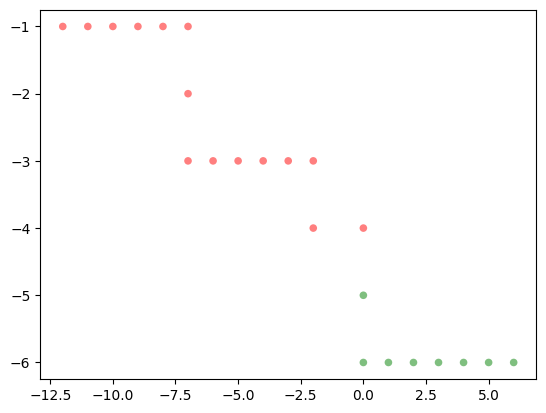

In [16]:
coords = getCoords(df)
dict_tuple = getMapPlot(df,coords)
df78 = dfFromCoordDict(dict_tuple)
plot2DMap(df78)

In [ ]:
df5 = getCumulStat(filename_test_json)
printAxis(df5)

In [ ]:
n_df = recap_fight(df)
display(n_df)


In [19]:
filename_evolutionCurve = "evolutionCurve.csv"
filename_recap = "recap.csv"
filename_position = "position.csv"
df5.to_csv(path_out+filename_evolutionCurve, mode='a', sep=";")
df78.to_csv( path_out+filename_position, mode='a', sep=";")
n_df.to_csv(path_out+filename_recap, mode='a', sep=";")